# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

Target:

1. Add image augmentation and may be a layer or two
2. I feel image roataion should be around 22 to 45 degrees to et it right




---


Results: 

---


Parameters: 8.9k

---


Best Train Accuracy: 98.93 at 12th epoch

---


Best Test Accuracy: 99.5 at 15th epoch

---


Analysis:


1.   The model is underfitting a bit.
2.  We got there 99.4 at 9th epoch
3. put the 1x1 after GAP to achieve even furthur accuracy


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                    #    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-35.0, 35.0), fill=(1,)),

                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=8, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:

dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 26, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 24, RF = 5
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(dropout_value)

        ) # output_size = 22, RF = 7

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11, RF = 8
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(dropout_value)

        ) # output_size = 11, RF = 8

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)

        ) # output_size = 9, RF = 12
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 7, RF = 16

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)

        ) # output_size = 7, RF = 20
        self.convblock7a = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)

        ) # output_size = 7, RF = 24
        self.convblock7b = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)

        ) # output_size = 7, RF = 28

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)

        ) # output_size = 7, RF = 28   
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7),
           
        ) # output_size = 1, RF = 38


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock7a(x)
        x = self.convblock8(x)        
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              36
       BatchNorm2d-2            [-1, 4, 26, 26]               8
              ReLU-3            [-1, 4, 26, 26]               0
           Dropout-4            [-1, 4, 26, 26]               0
            Conv2d-5            [-1, 4, 24, 24]             144
       BatchNorm2d-6            [-1, 4, 24, 24]               8
              ReLU-7            [-1, 4, 24, 24]               0
           Dropout-8            [-1, 4, 24, 24]               0
            Conv2d-9            [-1, 8, 22, 22]             288
      BatchNorm2d-10            [-1, 8, 22, 22]              16
             ReLU-11            [-1, 8, 22, 22]               0
          Dropout-12            [-1, 8, 22, 22]               0
        MaxPool2d-13            [-1, 8, 11, 11]               0
           Conv2d-14            [-

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
l1_factor = 0.00001

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  cross_entropy = nn.CrossEntropyLoss().to(device)

  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    # loss = F.nll_loss(y_pred, target)
    loss = cross_entropy(y_pred, target)
    # l1_crit = nn.L1Loss(reduce=False)
    reg_loss = 0
    for param in model.parameters():
        reg_loss += torch.sum(abs(param))

    loss += l1_factor * reg_loss
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9,weight_decay=.000001)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.17355012893676758 Batch_id=468 Accuracy=85.91: 100%|██████████| 469/469 [00:15<00:00, 30.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0785, Accuracy: 9759/10000 (97.59%)

EPOCH: 1


Loss=0.18823325634002686 Batch_id=468 Accuracy=95.78: 100%|██████████| 469/469 [00:15<00:00, 47.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0717, Accuracy: 9771/10000 (97.71%)

EPOCH: 2


Loss=0.16708874702453613 Batch_id=468 Accuracy=96.44: 100%|██████████| 469/469 [00:15<00:00, 30.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0692, Accuracy: 9787/10000 (97.87%)

EPOCH: 3


Loss=0.11712963879108429 Batch_id=468 Accuracy=96.92: 100%|██████████| 469/469 [00:15<00:00, 30.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0392, Accuracy: 9872/10000 (98.72%)

EPOCH: 4


Loss=0.1623612940311432 Batch_id=468 Accuracy=97.13: 100%|██████████| 469/469 [00:15<00:00, 29.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0496, Accuracy: 9848/10000 (98.48%)

EPOCH: 5


Loss=0.0619300976395607 Batch_id=468 Accuracy=97.21: 100%|██████████| 469/469 [00:14<00:00, 31.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0411, Accuracy: 9864/10000 (98.64%)

EPOCH: 6


Loss=0.09916630387306213 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:15<00:00, 31.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0389, Accuracy: 9877/10000 (98.77%)

EPOCH: 7


Loss=0.06395518034696579 Batch_id=468 Accuracy=97.53: 100%|██████████| 469/469 [00:15<00:00, 30.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9901/10000 (99.01%)

EPOCH: 8


Loss=0.08289650827646255 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:15<00:00, 30.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9893/10000 (98.93%)

EPOCH: 9


Loss=0.0639580488204956 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:15<00:00, 30.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9885/10000 (98.85%)

EPOCH: 10


Loss=0.14652404189109802 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:15<00:00, 30.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 9897/10000 (98.97%)

EPOCH: 11


Loss=0.07900920510292053 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:15<00:00, 37.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9902/10000 (99.02%)

EPOCH: 12


Loss=0.11698167026042938 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:14<00:00, 31.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9884/10000 (98.84%)

EPOCH: 13


Loss=0.0761067196726799 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:15<00:00, 44.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9904/10000 (99.04%)

EPOCH: 14


Loss=0.06912984699010849 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:15<00:00, 30.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0389, Accuracy: 9882/10000 (98.82%)

EPOCH: 15


Loss=0.04792753979563713 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:16<00:00, 29.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9890/10000 (98.90%)

EPOCH: 16


Loss=0.04469456523656845 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:15<00:00, 29.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9902/10000 (99.02%)

EPOCH: 17


Loss=0.04826335236430168 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:15<00:00, 30.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9910/10000 (99.10%)

EPOCH: 18


Loss=0.07209373265504837 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:15<00:00, 29.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Accuracy: 9880/10000 (98.80%)

EPOCH: 19


Loss=0.05814699828624725 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:15<00:00, 30.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9904/10000 (99.04%)

EPOCH: 20


Loss=0.09843981266021729 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:15<00:00, 29.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9907/10000 (99.07%)

EPOCH: 21


Loss=0.06408733874559402 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:15<00:00, 43.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9890/10000 (98.90%)

EPOCH: 22


Loss=0.04902911186218262 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:15<00:00, 29.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9892/10000 (98.92%)

EPOCH: 23


Loss=0.06515961140394211 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:15<00:00, 30.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9899/10000 (98.99%)

EPOCH: 24


Loss=0.02689528837800026 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:16<00:00, 28.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9907/10000 (99.07%)

EPOCH: 25


Loss=0.08058790862560272 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:15<00:00, 29.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9923/10000 (99.23%)

EPOCH: 26


Loss=0.030818695202469826 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:15<00:00, 30.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9897/10000 (98.97%)

EPOCH: 27


Loss=0.05475354194641113 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:15<00:00, 45.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9909/10000 (99.09%)

EPOCH: 28


Loss=0.032671988010406494 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:15<00:00, 30.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9917/10000 (99.17%)

EPOCH: 29


Loss=0.1209334060549736 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:15<00:00, 42.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9904/10000 (99.04%)

EPOCH: 30


Loss=0.05858734995126724 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:15<00:00, 29.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9909/10000 (99.09%)

EPOCH: 31


Loss=0.09742415696382523 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:15<00:00, 29.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9901/10000 (99.01%)

EPOCH: 32


Loss=0.07651207596063614 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:16<00:00, 29.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9910/10000 (99.10%)

EPOCH: 33


Loss=0.10860086977481842 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:15<00:00, 29.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9909/10000 (99.09%)

EPOCH: 34


Loss=0.1496281772851944 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:15<00:00, 29.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9907/10000 (99.07%)

EPOCH: 35


Loss=0.09818615019321442 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:15<00:00, 29.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9915/10000 (99.15%)

EPOCH: 36


Loss=0.07051780819892883 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:15<00:00, 29.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9927/10000 (99.27%)

EPOCH: 37


Loss=0.13168831169605255 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:15<00:00, 43.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9918/10000 (99.18%)

EPOCH: 38


Loss=0.07710053771734238 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:15<00:00, 29.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9920/10000 (99.20%)

EPOCH: 39


Loss=0.1202305406332016 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:15<00:00, 44.09it/s]



Test set: Average loss: 0.0285, Accuracy: 9914/10000 (99.14%)



In [0]:
import pickle
val_data = {'test_acc':test_acc,'test_losses':test_losses}


In [0]:
with open('EVAS6-l1_l2-1e-5_1e-6.pkl','wb') as f:
    pickle.dump(val_data,f)

In [0]:
with open ('EVAS6-l1-1e-5.pkl','rb') as f:
    l1_dict = pickle.load(f)

In [0]:
with open ('EVAS6-l2-1e-6.pkl','rb') as f:
    l2_dict = pickle.load(f)

In [0]:
with open ('EVAS6_base.pkl','rb') as f:
    base_dict = pickle.load(f)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
def find_missclassified(model,num_img=25):
    images = targ_list = pred_list = []
    count = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim = 1, keepdim = True).view_as(target)
            for d, t, p in zip(data, target, pred):
                 
                if t != p:
                    d = d.cpu().numpy()
                    t = t.cpu().numpy()
                    p = p.cpu().numpy()
                    d = (d * 0.3081) + 0.1307
                    # print(d.shape)
                    d = np.moveaxis(d,0,-1)
                    # print(d.shape)
                    images.append(d)
                    targ_list.append(t)
                    pred_list.append(p)
                    count += 1
                    d = np.reshape(d,(28,28))
                    plt.imshow(d,cmap='gray_r')
                    img_path = "l1_missclassified_img/"+str(count)+"_"+str(p)+"_"+str(t)+".jpg"
                    plt.savefig(img_path) #some small error with PIL so some simple jugaad to get the job done
                    

                if count == num_img:
                    return images, targ_list, pred_list #inefficiently breaking out of loop

In [0]:
a = find_missclassified(model)

## Validation Accuracy

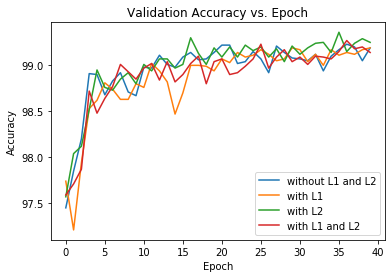

In [0]:
plt.plot(base_dict['test_acc'],label = 'without L1 and L2')
plt.plot(l1_dict['test_acc'],label = 'with L1')
plt.plot(l2_dict['test_acc'],label = 'with L2')
plt.plot(test_acc,label = 'with L1 and L2')
plt.title('Validation Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('evas6-acc.png',dpi=150)

## Test Loss

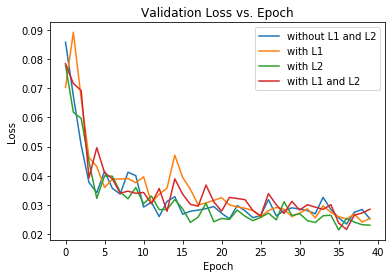

In [0]:
plt.plot(base_dict['test_losses'],label = 'without L1 and L2')
plt.plot(l1_dict['test_losses'],label = 'with L1')
plt.plot(l2_dict['test_losses'],label = 'with L2')
plt.plot(test_losses,label = 'with L1 and L2')
plt.title('Validation Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('evas6-loss.png',dpi=150)

In [0]:
!nvidia-smi

Sat Feb 29 16:06:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    26W /  75W |    603MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Text(0.5, 1.0, 'Test Accuracy')

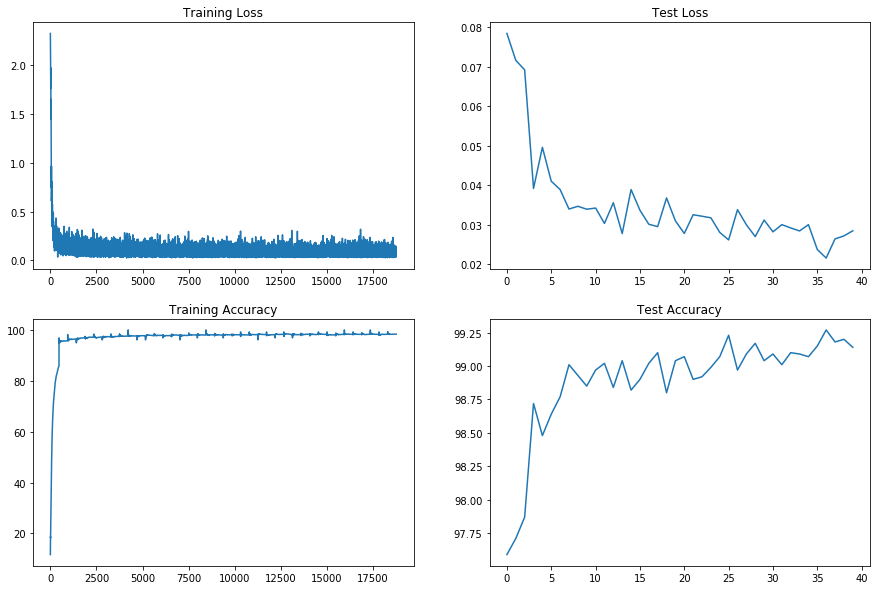

In [0]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")